In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn import metrics

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.ToTensor(),
])

traindataset = datasets.STL10('./downloads/', download=True, split='train', transform=transform)
testdataset = datasets.STL10('./downloads/', download=True, split='test', transform=transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./downloads/stl10_binary.tar.gz to ./downloads/
Files already downloaded and verified


In [5]:
print(f'traindataset =>{traindataset.data.shape}')
print(f'testdataset =>{testdataset.data.shape}')

traindataset =>(5000, 3, 96, 96)
testdataset =>(8000, 3, 96, 96)


In [6]:

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000, shuffle=False, num_workers=2)

torch.Size([1000, 3, 96, 96])


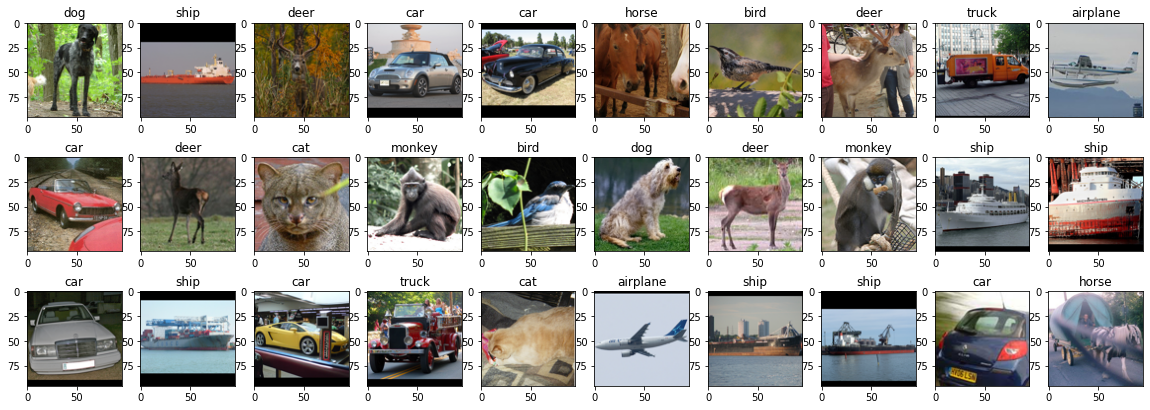

In [7]:
def view_samples():
    
    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu())
    plt.show()
view_samples()

In [8]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

In [9]:
import time
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
# Train the model
def model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            train_acc += metrics.accuracy_score(labels.cpu().data.numpy(),outputs.cpu().data.numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, labels = next(iter(testloader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*images.size(0)
            val_acc += metrics.accuracy_score(labels.cpu().data.numpy(),outputs.cpu().data.numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    print(f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list),time.time()-start,loss_list[-1][2],loss_list[-1][3]


In [11]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

Selected optimizer : Adam
Epoch: 1 (0m 7s) 	Training Loss: 219.623, 	Test Loss: 214.788,  	Training acc: 0.21, 	Test acc: 0.38, 
Epoch: 2 (0m 13s) 	Training Loss: 141.382, 	Test Loss: 152.887,  	Training acc: 0.57, 	Test acc: 0.67, 
Epoch: 3 (0m 20s) 	Training Loss: 98.121, 	Test Loss: 116.141,  	Training acc: 0.75, 	Test acc: 0.76, 
Epoch: 4 (0m 27s) 	Training Loss: 72.217, 	Test Loss: 94.309,  	Training acc: 0.83, 	Test acc: 0.80, 
Epoch: 5 (0m 34s) 	Training Loss: 55.927, 	Test Loss: 81.401,  	Training acc: 0.87, 	Test acc: 0.82, 
Epoch: 6 (0m 40s) 	Training Loss: 44.818, 	Test Loss: 72.610,  	Training acc: 0.89, 	Test acc: 0.83, 
Epoch: 7 (0m 47s) 	Training Loss: 36.772, 	Test Loss: 66.610,  	Training acc: 0.92, 	Test acc: 0.84, 
Epoch: 8 (0m 55s) 	Training Loss: 29.995, 	Test Loss: 62.523,  	Training acc: 0.94, 	Test acc: 0.85, 
Epoch: 9 (1m 1s) 	Training Loss: 24.854, 	Test Loss: 59.246,  	Training acc: 0.96, 	Test acc: 0.86, 
Epoch: 10 (1m 8s) 	Training Loss: 20.300, 	Test Loss:

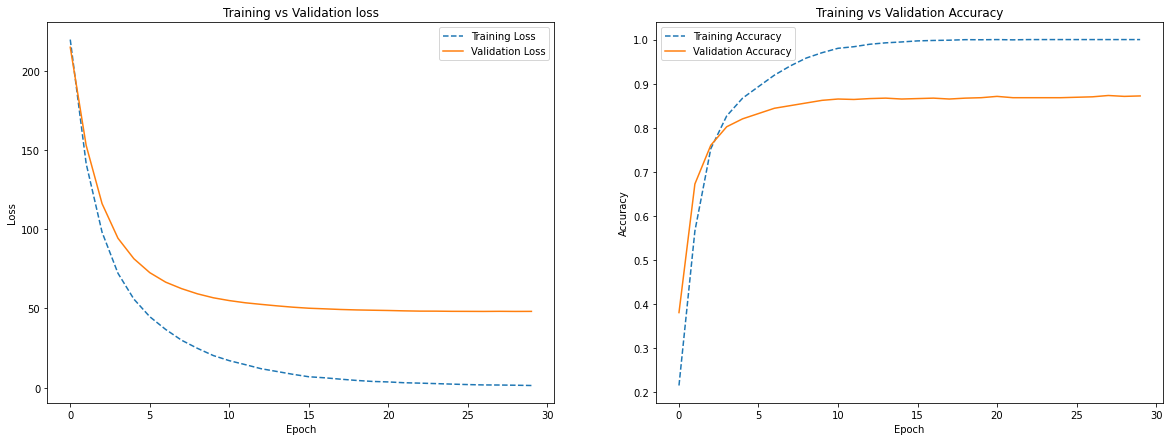

Confusion Matrix for : Adam


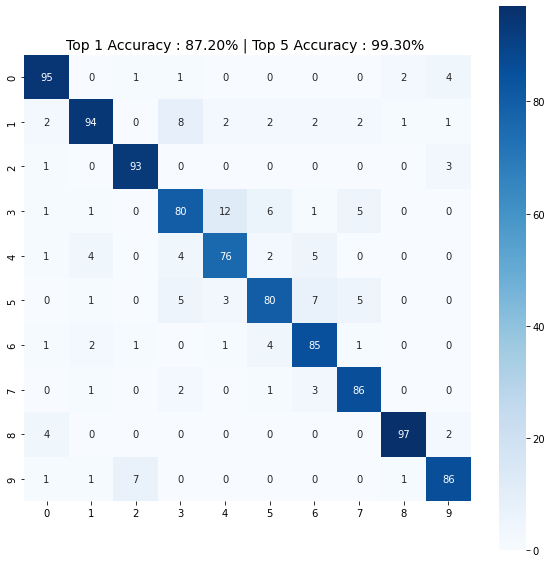

Top 1 Accuracy: 87.200%
Top 5 Accuracy: 99.3%
Classwise Accuracy Score: 
[0.9223301  0.8245614  0.95876289 0.75471698 0.82608696 0.79207921
 0.89473684 0.92473118 0.94174757 0.89583333]
Selected optimizer : Adagrad
Epoch: 1 (0m 6s) 	Training Loss: 248.095, 	Test Loss: 299.976,  	Training acc: 0.12, 	Test acc: 0.15, 
Epoch: 2 (0m 12s) 	Training Loss: 227.337, 	Test Loss: 284.108,  	Training acc: 0.18, 	Test acc: 0.18, 
Epoch: 3 (0m 19s) 	Training Loss: 216.093, 	Test Loss: 272.681,  	Training acc: 0.22, 	Test acc: 0.20, 
Epoch: 4 (0m 25s) 	Training Loss: 207.393, 	Test Loss: 263.464,  	Training acc: 0.25, 	Test acc: 0.23, 
Epoch: 5 (0m 32s) 	Training Loss: 199.521, 	Test Loss: 255.669,  	Training acc: 0.29, 	Test acc: 0.25, 
Epoch: 6 (0m 38s) 	Training Loss: 193.680, 	Test Loss: 248.874,  	Training acc: 0.32, 	Test acc: 0.28, 
Epoch: 7 (0m 45s) 	Training Loss: 188.275, 	Test Loss: 242.848,  	Training acc: 0.35, 	Test acc: 0.29, 
Epoch: 8 (0m 51s) 	Training Loss: 183.689, 	Test Loss: 237

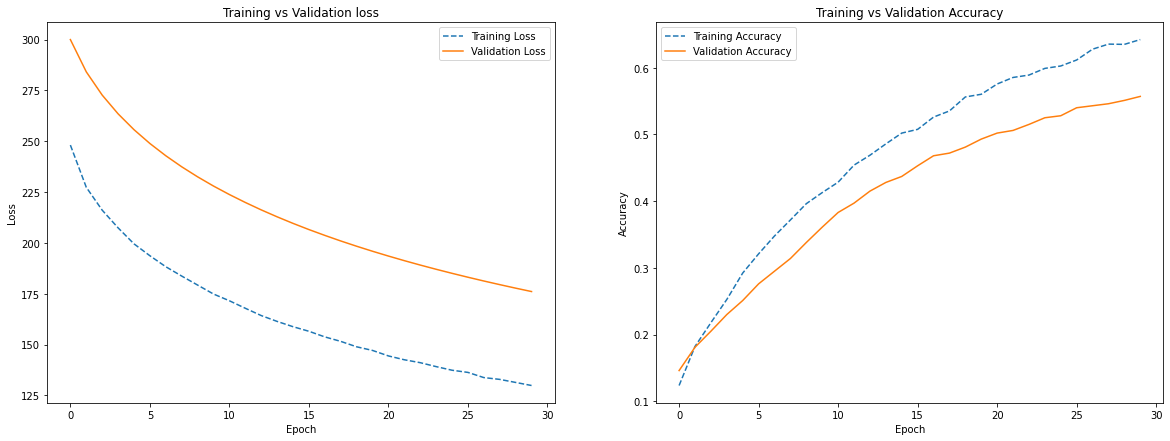

Confusion Matrix for : Adagrad


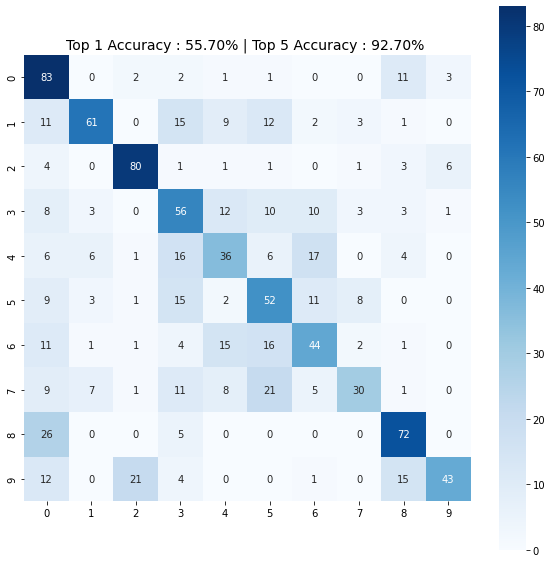

Top 1 Accuracy: 55.700%
Top 5 Accuracy: 92.7%
Classwise Accuracy Score: 
[0.80582524 0.53508772 0.82474227 0.52830189 0.39130435 0.51485149
 0.46315789 0.32258065 0.69902913 0.44791667]
Selected optimizer : Adadelta
Epoch: 1 (0m 6s) 	Training Loss: 272.771, 	Test Loss: 336.632,  	Training acc: 0.10, 	Test acc: 0.11, 
Epoch: 2 (0m 13s) 	Training Loss: 272.887, 	Test Loss: 336.342,  	Training acc: 0.10, 	Test acc: 0.11, 
Epoch: 3 (0m 20s) 	Training Loss: 272.154, 	Test Loss: 336.049,  	Training acc: 0.11, 	Test acc: 0.11, 
Epoch: 4 (0m 27s) 	Training Loss: 272.330, 	Test Loss: 335.754,  	Training acc: 0.11, 	Test acc: 0.11, 
Epoch: 5 (0m 33s) 	Training Loss: 272.060, 	Test Loss: 335.457,  	Training acc: 0.11, 	Test acc: 0.11, 
Epoch: 6 (0m 40s) 	Training Loss: 271.217, 	Test Loss: 335.159,  	Training acc: 0.10, 	Test acc: 0.11, 
Epoch: 7 (0m 47s) 	Training Loss: 271.337, 	Test Loss: 334.861,  	Training acc: 0.11, 	Test acc: 0.11, 
Epoch: 8 (0m 53s) 	Training Loss: 270.775, 	Test Loss: 33

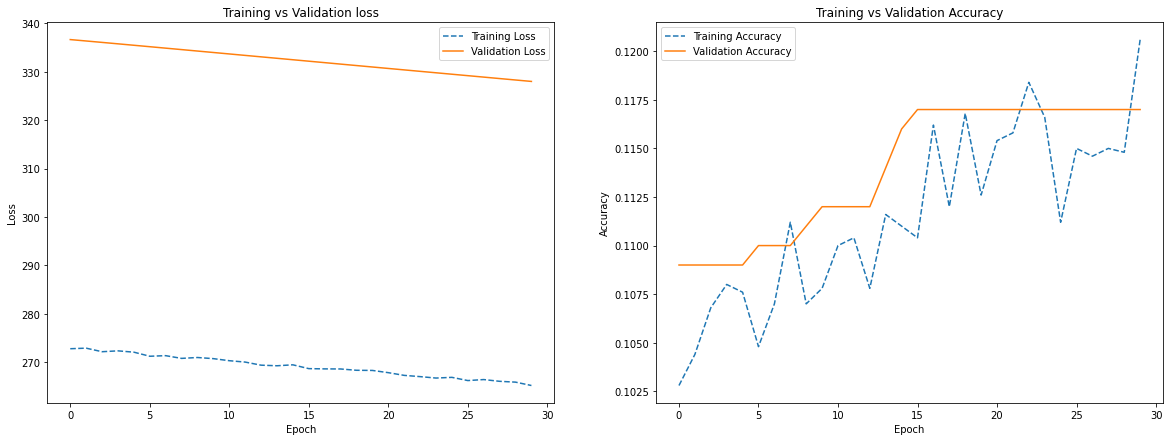

Confusion Matrix for : Adadelta


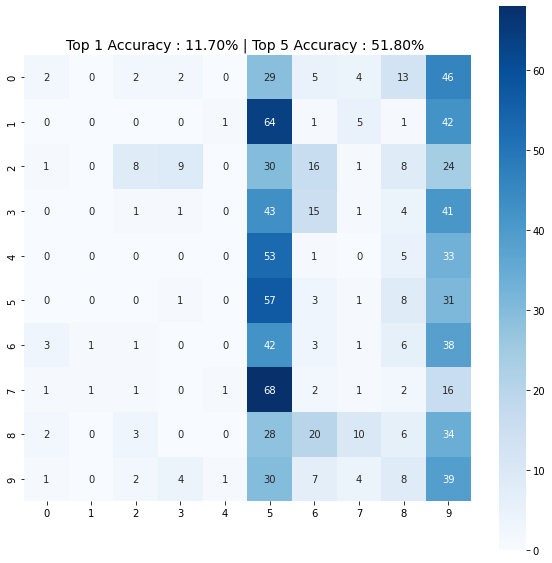

Top 1 Accuracy: 11.700%
Top 5 Accuracy: 51.800000000000004%
Classwise Accuracy Score: 
[0.01941748 0.         0.08247423 0.00943396 0.         0.56435644
 0.03157895 0.01075269 0.05825243 0.40625   ]
Selected optimizer : RMSprop
Epoch: 1 (0m 7s) 	Training Loss: 139.981, 	Test Loss: 120.008,  	Training acc: 0.58, 	Test acc: 0.75, 
Epoch: 2 (0m 13s) 	Training Loss: 72.837, 	Test Loss: 90.944,  	Training acc: 0.82, 	Test acc: 0.81, 
Epoch: 3 (0m 20s) 	Training Loss: 52.198, 	Test Loss: 76.564,  	Training acc: 0.88, 	Test acc: 0.83, 
Epoch: 4 (0m 27s) 	Training Loss: 39.249, 	Test Loss: 67.516,  	Training acc: 0.92, 	Test acc: 0.85, 
Epoch: 5 (0m 34s) 	Training Loss: 30.721, 	Test Loss: 61.823,  	Training acc: 0.94, 	Test acc: 0.86, 
Epoch: 6 (0m 40s) 	Training Loss: 24.053, 	Test Loss: 57.964,  	Training acc: 0.96, 	Test acc: 0.86, 
Epoch: 7 (0m 47s) 	Training Loss: 18.548, 	Test Loss: 54.648,  	Training acc: 0.97, 	Test acc: 0.87, 
Epoch: 8 (0m 53s) 	Training Loss: 14.688, 	Test Loss: 52

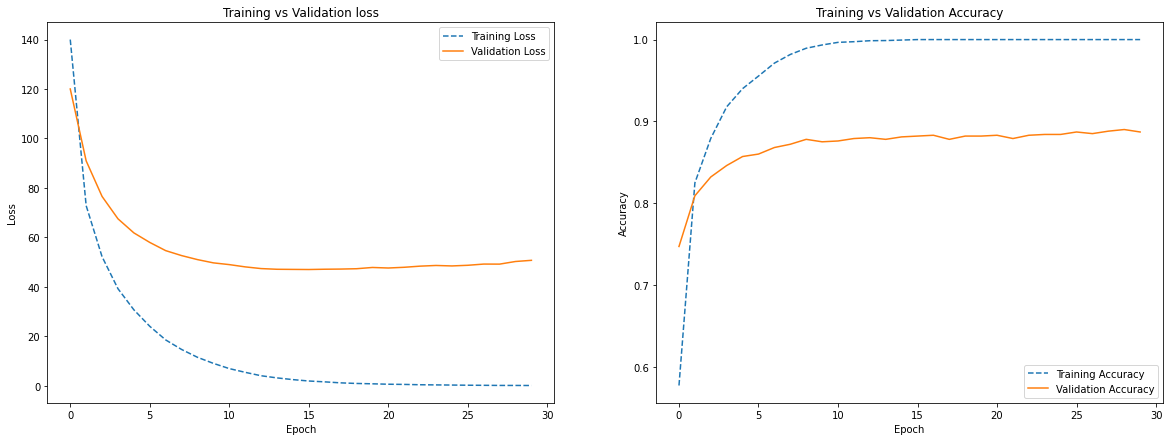

Confusion Matrix for : RMSprop


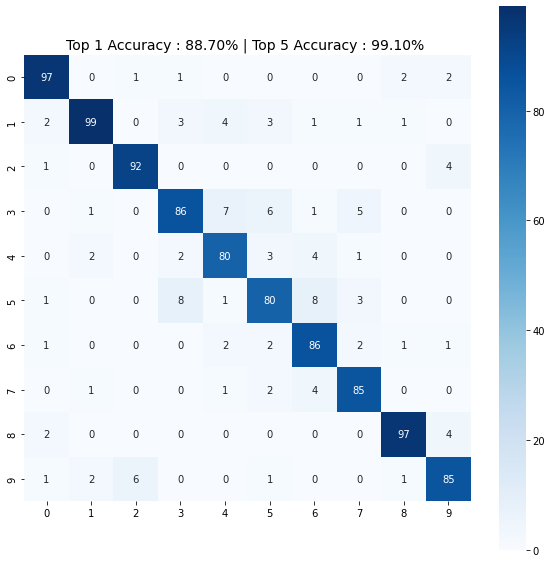

Top 1 Accuracy: 88.700%
Top 5 Accuracy: 99.1%
Classwise Accuracy Score: 
[0.94174757 0.86842105 0.94845361 0.81132075 0.86956522 0.79207921
 0.90526316 0.91397849 0.94174757 0.88541667]


In [22]:
selected_optimizers:list[torch.optim.Optimizer] = [torch.optim.Adam,torch.optim.Adagrad,torch.optim.Adadelta,torch.optim.RMSprop]
selected_optimizers_names = ['Adam','Adagrad','Adadelta','RMSprop']
trng_time_list = []
trng_acc_list = []
test_acc_list = []
for i,optimizer in enumerate(selected_optimizers):
    print(f'Selected optimizer : {selected_optimizers_names[i]}')
    # Load the pre-trained ResNet18 model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Replace the final fully connected layer
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    # Define the optimizer and loss function
    model.to(device)

    optimizer_inst =  optimizer(model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss()
    loss_list,t,train_a,test_a = model_training(model,criterion,optimizer_inst,trainloader,testloader,num_epochs=30)
    trng_time_list.append(t)
    trng_acc_list.append(train_a)
    test_acc_list.append(test_a)
    plot_training_graphs(loss_list)
    test_images, test_labels = next(iter(testloader))
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_output = model(test_images)
    with torch.no_grad():
        print(f'Confusion Matrix for : {selected_optimizers_names[i]}')
        confusionMatrixAndAccuracyReport(test_labels.cpu().data.numpy(),test_output.cpu().data.numpy(),testdataset.classes)

## Comparison

In [23]:
import pandas as pd

df = pd.DataFrame()
df['optimizer']=selected_optimizers_names
df['trng_acc']=trng_acc_list
df['test_acc']=test_acc_list
df['trng_time']=trng_time_list
print(df.to_markdown())

|    | optimizer   |   trng_acc |   test_acc |   trng_time |
|---:|:------------|-----------:|-----------:|------------:|
|  0 | Adam        |     1      |      0.872 |     208.165 |
|  1 | Adagrad     |     0.6422 |      0.557 |     196.661 |
|  2 | Adadelta    |     0.1206 |      0.117 |     199.787 |
|  3 | RMSprop     |     1      |      0.887 |     199.775 |


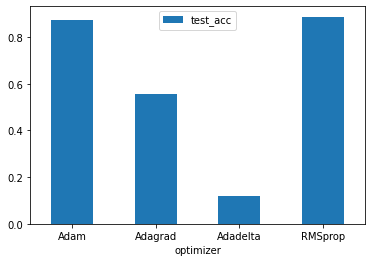

In [24]:
ax = df.plot(x="optimizer", y=["test_acc"], kind="bar", rot=0,) #, "trng_acc", "trng_time"